In [21]:
import matplotlib
#matplotlib.use('Qt5Agg')
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prim
import seaborn as sns
from sklearn import mixture

In [106]:
sns.set_context("notebook",rc={"font.size": 18})
sns.set_style("whitegrid")

data = pd.read_excel("Emission.xlsx","CO2_nolimit")

new_data = data.set_index(['DMD', 'FUEL', 'CC RE', 'DR', 'CO2', 'CC','Scenario', 'Emission', 'Cost']).reset_index()


In [107]:
inputs = new_data[['DMD', 'FUEL', 'CC RE', 'DR', 'CC']]

new_data['tot_cost'] = new_data['Cost']

new_data.head(2)

,DMD,FUEL,CC RE,DR,CO2,CC,Scenario,Emission,Cost,Parameter,Discounted Costs,tot_cost
0,1,3,1,1,3,2,131132,44.452794,0.914374,AnnualEmissions,914373.584771,0.914374
1,1,3,1,1,3,1,131131,44.737064,0.914091,AnnualEmissions,914090.983798,0.914091


In [117]:
def clustering(n_clusters, data, xstring, ystring):
    g = mixture.GaussianMixture(n_components=n_clusters)
    g.fit(data_norm)
    pred = g.predict(data_norm) + 1

    x = []
    y = []
    for i in range(0, len(data)):
        x.append(data[i][0])
        y.append(data[i][1])

    df = pd.DataFrame()
    df[xstring] = x
    df[ystring] = y
    df['class'] = pred
    return df

In [118]:
def get_prim(n_clusters, f_value,data,xstring,ystring,inputs):

    df = clustering(n_clusters,data,xstring,ystring)
    classes = df[['class']].drop_duplicates()['class']
    list_prim =[]
    sorted(classes)

    for i in range(1,max(classes)+1):
        list_prim.append(prim.Prim(inputs, (df['class']==i),threshold=0.5,threshold_type=">"))

    boxes = []

    for i in range(0,len(list_prim)):
        boxes.append(list_prim[i].find_box())
        obj = (f_value*boxes[i].peeling_trajectory['coverage']-(1-f_value)*boxes[i].peeling_trajectory['density'])**2
        if 1 in boxes[i].peeling_trajectory['coverage']:
            coverage1 = np.where(boxes[i].peeling_trajectory['coverage']==1)[0][0]
            obj = obj.drop(obj.index[[coverage1]])
        k = obj.argmin()
        boxes[i].select(k)

    return [boxes,df]

In [119]:
def normalize(data):
    minima = np.min(data, axis=0)
    maxima = np.max(data, axis=0)
    a = 1/(maxima-minima)
    b = minima/(minima-maxima)
    data = a * data + b
    return data


In [120]:
oois = ['Cost','Emission']

data = np.array([[new_data[oois[0]][0],new_data[oois[1]][0]]])
for i in range(1,len(new_data.index)):
    data = np.concatenate((data,np.array([[new_data[oois[0]][i],new_data[oois[1]][i]]])))

data_norm = normalize(data)

n_clusters = 3
f_value = 0.5
seuil = 1.2

In [121]:
while n_clusters>2:

    condition = True

    for i in get_prim(n_clusters, f_value, data,oois[0],oois[1],inputs)[0]:
        if i.coverage+i.density < seuil:
            condition = False
        else:
            condition = condition&True
    if condition == True:
        break
    else:
        n_clusters = n_clusters - 1
        continue

In [122]:
dummy = get_prim(n_clusters, f_value, data,oois[0],oois[1],inputs)
boxes = dummy[0]
df = dummy[1]

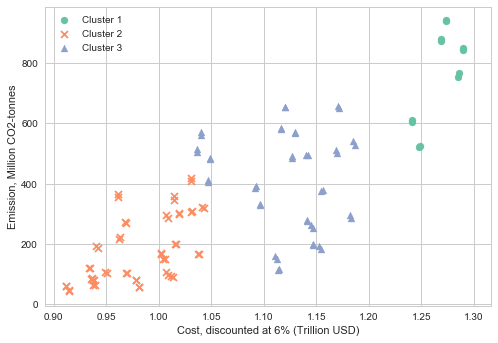

In [123]:
mycolors = ["#66c2a5","#fc8d62","#8da0cb","#e78ac3"]
mymarks = ["o","x","^","s"]
for (i,subdf) in df.groupby("class"):

    plt.scatter(subdf.Cost,subdf.Emission, label="Cluster {}".format(i),c=mycolors[i-1],marker=mymarks[i-1])
    
plt.legend()
plt.ylabel("Emission, Million CO2-tonnes")
plt.xlabel("Cost, discounted at 6% (Trillion USD)")
plt.savefig("Emissions_cluster.png")
#plt.show ()

In [124]:
print(boxes[0].limits)

print(boxes[1].limits)

print(boxes[2].limits)

#print(boxes[3].limits)

print(inputs.describe())

     min  max  qp values
DMD  3.0  3.0   0.000002
DR   3.0  3.0   0.000002
     min  max     qp values
DMD  1.0  2.0  3.528739e-09
DR   1.0  2.0  1.645132e-07
     min  max  qp values
DMD  3.0  3.0   0.001495
              DMD        FUEL       CC RE          DR          CC
count  108.000000  108.000000  108.000000  108.000000  108.000000
mean     2.000000    2.000000    2.000000    2.000000    1.500000
std      0.820303    1.004662    0.820303    0.820303    0.502331
min      1.000000    1.000000    1.000000    1.000000    1.000000
25%      1.000000    1.000000    1.000000    1.000000    1.000000
50%      2.000000    2.000000    2.000000    2.000000    1.500000
75%      3.000000    3.000000    3.000000    3.000000    2.000000
max      3.000000    3.000000    3.000000    3.000000    2.000000


In [125]:
boxes[0].coverage,boxes[0].density


(1.0, 1.0)

In [126]:
boxes[1].coverage,boxes[1].density


(0.92307692307692313, 1.0)

In [127]:
boxes[2].coverage,boxes[2].density

(0.54545454545454541, 0.66666666666666663)